In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from scipy.stats import truncnorm
import matplotlib.pylab as pylab
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from scipy.stats import zscore
import xgboost as xgb
import lightgbm as lgb
import joblib

In [3]:
#tạo DataFrame với các cột đã được số hóa
df_raw = pd.read_csv('C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/data/batdongsan/numerized/Dat_numerized-dataset.csv',index_col=False)

In [4]:
df_raw.describe()

,Unnamed: 0,DienTich,City,District,MucGia,MatTien,DuongVao,PhapLy,Lat,Long,Ward
count,23891.000000,2.389000e+04,23890.000000,23882.000000,2.006100e+04,16077.000000,14732.00000,19304.000000,22236.000000,22236.000000,23670.000000
mean,11945.000000,3.174427e+03,48.027375,506.235701,2.710382e+10,13.257537,10.94797,1.019322,15.069132,106.701299,18357.783481
std,6896.881977,1.358244e+05,32.165415,280.078700,1.801642e+12,26.880638,18.28162,0.225297,4.776611,1.112883,9994.157208
min,0.000000,8.100000e+00,1.000000,1.000000,2.350000e+03,0.380000,0.30000,0.000000,-119.417932,36.778261,4.000000
25%,5972.500000,8.500000e+01,1.000000,275.000000,1.600000e+09,5.000000,5.00000,1.000000,10.849028,105.856533,9898.000000
50%,11945.000000,1.360000e+02,60.000000,593.000000,3.700000e+09,6.000000,8.00000,1.000000,12.025325,106.638670,22915.000000
75%,17917.500000,4.060000e+02,79.000000,761.000000,9.000000e+09,11.000000,12.00000,1.000000,20.945650,107.001625,26767.000000
max,23890.000000,1.500000e+07,96.000000,973.000000,2.550000e+14,818.000000,942.00000,4.000000,30.821266,111.788312,32244.000000


In [5]:
rows  = df_raw[df_raw['MucGia'] < 200000000]
df_raw = df_raw.drop(index = rows.index)
rows  = df_raw[df_raw['MucGia'] > 200000000000]
df_raw = df_raw.drop(index = rows.index)
rows  = df_raw[df_raw['DienTich'] >1000]
df_raw = df_raw.drop(index = rows.index)

df_raw = df_raw.dropna(subset=['City', 'District', 'Ward','MucGia'])

df_raw = df_raw.drop(columns=['Unnamed: 0'])

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16749 entries, 2 to 23889
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DienTich  16749 non-null  float64
 1   DiaChi    16749 non-null  object 
 2   City      16749 non-null  float64
 3   District  16749 non-null  float64
 4   MucGia    16749 non-null  float64
 5   MatTien   12054 non-null  float64
 6   DuongVao  11006 non-null  float64
 7   PhapLy    13749 non-null  float64
 8   Lat       15631 non-null  float64
 9   Long      15631 non-null  float64
 10  Ward      16749 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.5+ MB


In [7]:
df_raw = df_raw.drop(columns=['Lat','Long'])

In [8]:

# Hàm để điền các giá trị bị thiếu trong một cột số
def fill_missing_with_random(column):
    if column.dtype.kind in 'biufc':  # Kiểm tra nếu cột là số
        # Tính trung bình và độ lệch chuẩn của cột (bỏ qua giá trị bị thiếu)
        mean = np.mean(column.dropna())
        std = np.std(column.dropna())
        
        # Xác định vị trí các giá trị bị thiếu
        missing_indices = np.where(column.isnull())[0]
        # Sinh giá trị ngẫu nhiên từ phân phối chuẩn
        random_data = np.random.normal(loc=mean, scale=std, size=len(missing_indices))
        # Đảm bảo không có giá trị âm
        random_data = np.abs(random_data)
        
        # Điền giá trị bị thiếu bằng các giá trị ngẫu nhiên đã sinh ra
        column.iloc[missing_indices] = random_data
        
    return column

def zero_round(value):
    if value < 0.5:
        return 0
    elif value < 1:
        return 1
    else:
        return np.floor(value)
    
df_raw['PhapLy'] = fill_missing_with_random(df_raw['PhapLy'])
df_raw['PhapLy'] = df_raw['PhapLy'].apply(zero_round)

C:\Users\quanp\AppData\Local\Temp\ipykernel_15408\614438999.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.iloc[missing_indices] = random_data


In [9]:
# Thiết kế biểu đồ
rcParams = {'xtick.labelsize':'14','ytick.labelsize':'14','axes.labelsize':'16'}

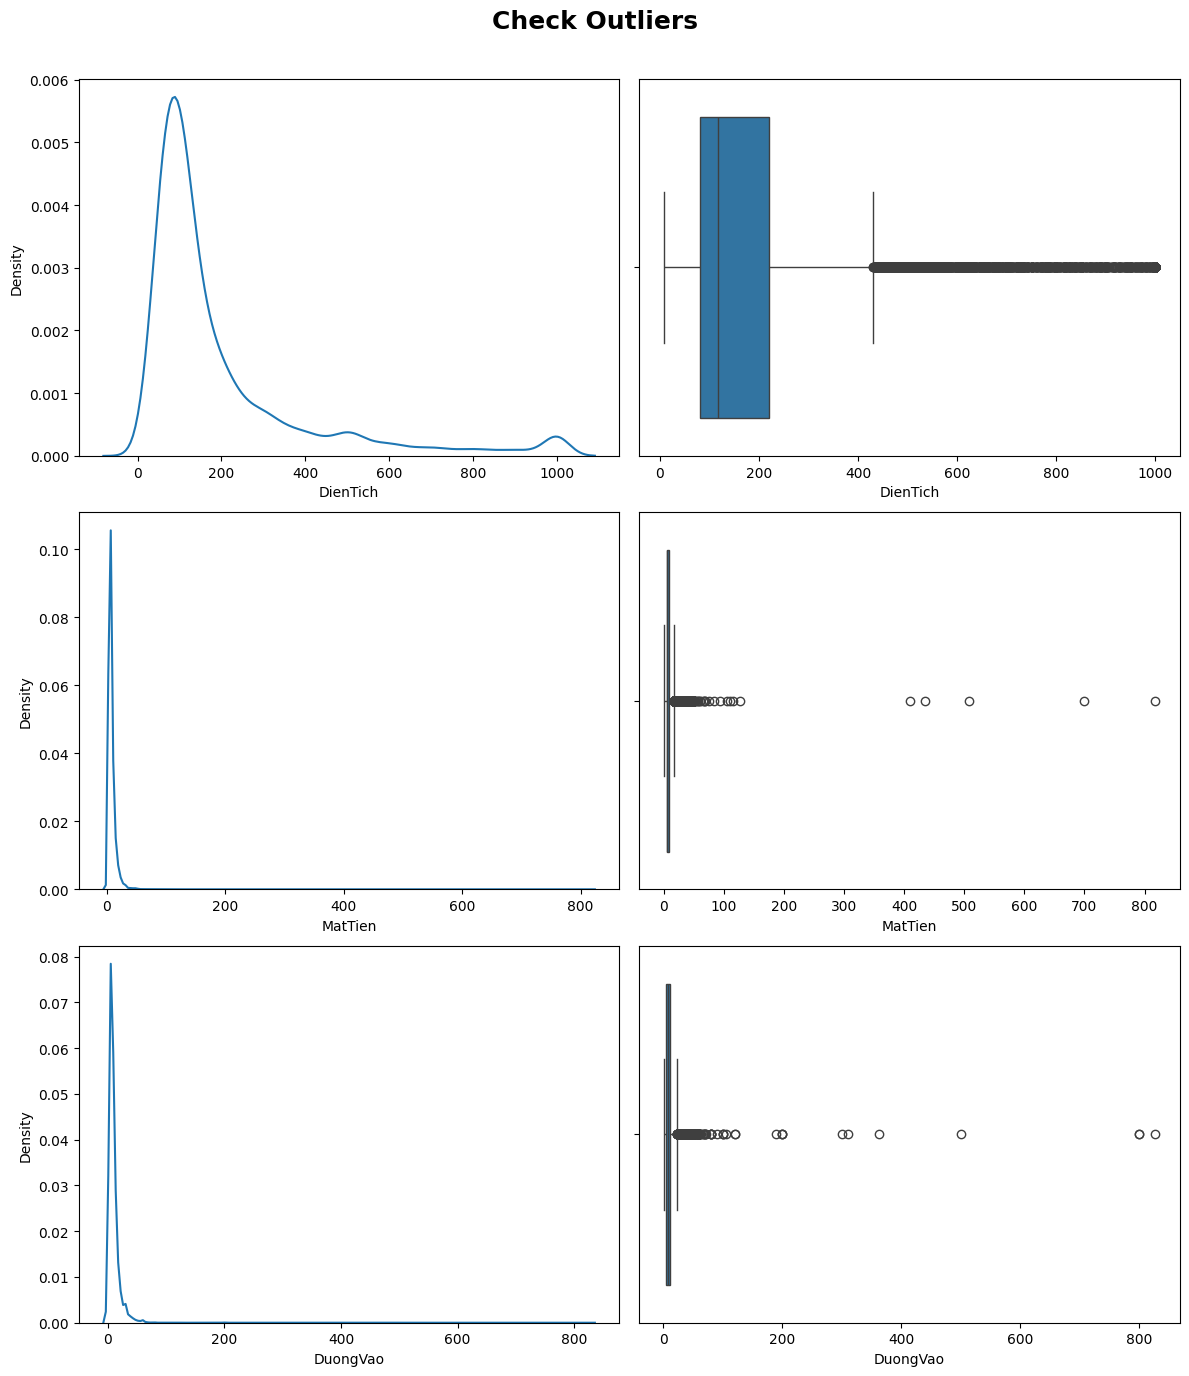

In [10]:
fig, ax = plt.subplots(3,2, figsize = (12,14))

fig.suptitle('Check Outliers', size = 18, fontweight="bold")
sns.kdeplot(ax= ax[0,0], data = df_raw, x = 'DienTich')
sns.boxplot(ax= ax[0,1], data = df_raw, x = 'DienTich')
sns.kdeplot(ax= ax[1,0], data = df_raw, x = 'MatTien')
sns.boxplot(ax= ax[1,1], data = df_raw, x = 'MatTien')
sns.kdeplot(ax= ax[2,0], data = df_raw, x = 'DuongVao')
sns.boxplot(ax= ax[2,1], data = df_raw, x = 'DuongVao')


pylab.rcParams.update(rcParams)
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

Diện Tích:  
- Biểu đồ trái:  
Biểu đồ mật độ này cho thấy phân phối của dữ liệu diện tích. Phân phối nghiêng về bên trái, với phần lớn các giá trị tập trung trong khoảng dưới 200 m².  
Có một số ít giá trị nằm ở khu vực lớn hơn 200 m², cho thấy sự hiện diện của một số giá trị ngoại lai ở phía cuối phân phối.  
- Biểu đồ phải:  
Biểu đồ hộp này biểu thị phân phối và sự hiện diện của các giá trị ngoại lai. Phần thân của hộp (box) cho thấy rằng phần lớn dữ liệu tập trung dưới 200 m².  
Các giá trị ngoại lai nằm ngoài giới hạn kéo dài đến khoảng 1000 m². Những điểm này biểu thị sự hiện diện của các giá trị ngoại lai có diện tích lớn hơn hẳn so với phần còn lại của dữ liệu.  
- Kết luận:  
Cả hai biểu đồ đều chỉ ra rằng có sự hiện diện của các giá trị ngoại lai trong dữ liệu diện tích, đặc biệt là những diện tích lớn hơn 200 m².
Mặt Tiền:  
- Biểu đồ bên trái:  
Biểu đồ mật độ cho thấy phần lớn dữ liệu tập trung ở các giá trị rất thấp của Mặt Tiền (gần 0).  
có một số giá trị lớn hơn nhưng xuất hiện ít hơn. Điều này gợi ý rằng dữ liệu bị lệch về phía phải.  
- Biểu đồ phải:  
Các giá trị ngoại lai này đặc biệt lớn, với một số điểm dữ liệu đạt giá trị trên 800m, điều này xác nhận sự phân phối lệch phải đã thấy trong biểu đồ mật độ.  
- Kết luận:  
Dữ liệu của Mặt Tiền chứa nhiều giá trị ngoại lai đáng kể, đặc biệt là ở phía giá trị cao. Những giá trị ngoại lai này đang ảnh hưởng mạnh đến phân phối của dữ liệu.
Đường Vào:  
- Biểu đồ bên trái:  
Biểu đồ mật độ cho thấy hầu hết dữ liệu Đường Vào tập trung tại các giá trị rất nhỏ (gần bằng 0).  
một số giá trị lớn nhưng với tần suất thấp, gợi ý rằng dữ liệu cũng bị lệch phải.  
- Biểu đồ bên phải: 
Biểu đồ hộp cho thấy một số lượng lớn các giá trị ngoại lai (outliers).  
Những giá trị ngoại lai này khá lớn, với một số điểm dữ liệu có giá trị vượt quá 800m.  
- Kết luận:  
Dữ liệu Đường Vào cũng có nhiều giá trị ngoại lai đáng kể, đặc biệt ở phía giá trị cao.

In [11]:
df_raw.describe()

,DienTich,City,District,MucGia,MatTien,DuongVao,PhapLy,Ward
count,16749.000000,16749.000000,16749.000000,1.674900e+04,12054.000000,11006.000000,16749.000000,16749.000000
mean,199.798140,46.525882,490.052839,7.957038e+09,8.206543,10.464792,1.014329,17808.320019
std,208.761911,32.489088,286.673177,1.552991e+10,13.456258,17.673122,0.206556,10220.022121
min,8.100000,1.000000,1.000000,2.000000e+08,0.380000,1.000000,0.000000,4.000000
25%,80.000000,1.000000,274.000000,1.550000e+09,5.000000,5.000000,1.000000,9877.000000
50%,118.000000,56.000000,568.000000,3.450000e+09,5.720000,7.500000,1.000000,22390.000000
75%,220.000000,79.000000,761.000000,7.500000e+09,9.650000,12.000000,1.000000,26764.000000
max,1000.000000,96.000000,973.000000,2.000000e+11,818.000000,827.000000,4.000000,32244.000000


In [12]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16749 entries, 2 to 23889
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DienTich  16749 non-null  float64
 1   DiaChi    16749 non-null  object 
 2   City      16749 non-null  float64
 3   District  16749 non-null  float64
 4   MucGia    16749 non-null  float64
 5   MatTien   12054 non-null  float64
 6   DuongVao  11006 non-null  float64
 7   PhapLy    16749 non-null  float64
 8   Ward      16749 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [13]:
#thêm một cột LogPrice để so sánh với các cột khác. Giúp giá trị nhỏ lại để dễ trực quan
df_raw['LogPrice'] = np.log(df_raw['MucGia'])

#thêm cột USD để về sau xây dựng mô hình với giá USD hạn chế được sai số do VND quá lớn (tỉ giá đổi 25k / 1$)
df_raw['USD']=df_raw['MucGia'].astype(float)/25000

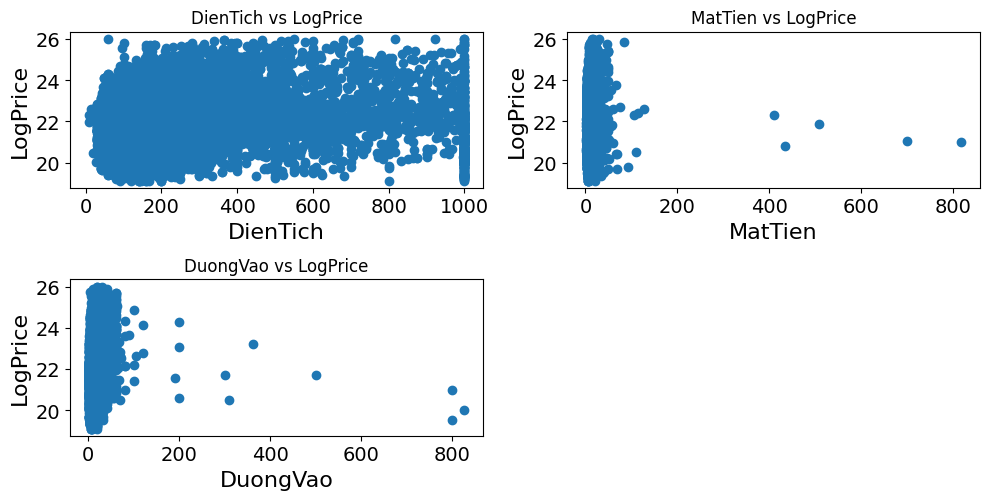

In [14]:
def scatter(x, fig, xlim=None):
    plt.subplot(5, 2, fig)
    plt.scatter(df_raw[x], df_raw['LogPrice'])
    plt.title(x + ' vs LogPrice')
    plt.ylabel('LogPrice')
    plt.xlabel(x)
    if xlim:
        plt.xlim(xlim)

plt.figure(figsize=(10, 12))

scatter('DienTich', 1)
scatter('MatTien', 2)
scatter('DuongVao', 3)

plt.tight_layout()
plt.show()

Diện Tích:  
Quan sát: Phân bố dữ liệu vẫn tương tự như trước, với một lượng lớn các điểm dữ liệu tập  
trung trong khoảng từ 0 đến 1000 về DienTich. Không có xu hướng rõ ràng về mối quan  
hệ giữa DienTich và LogPrice.  
Ảnh hưởng: DienTich tiếp tục không cho thấy mối quan hệ tuyến tính rõ ràng với  
LogPrice. Phân tán dữ liệu rộng cho thấy có thể có những yếu tố khác ảnh hưởng nhiều  
hơn đến LogPrice.  
Đường Vào:  
Quan sát: Biểu đồ này cũng mở rộng phạm vi DuongVao, nhưng phần lớn các điểm dữ liệu  
vẫn tập trung ở khoảng 0 đến 100. Một số ít điểm dữ liệu ở mức cao hơn cho thấy các bất  
động sản có bề rộng đường vào lớn, nhưng không có xu hướng rõ ràng với LogPrice.  
Ảnh hưởng: Tương tự như trước, DuongVao không thể hiện mối quan hệ tuyến tính rõ  
ràng với LogPrice. Phần lớn các bất động sản có bề rộng đường vào hẹp, và không có xu  
hướng rõ ràng cho thấy sự ảnh hưởng của yếu tố này đến LogPrice.  
Mặt Tiền:  
Quan sát: Biểu đồ đã mở rộng phạm vi của MatTien, với một số điểm dữ liệu xuất hiện ở  
các giá trị rất cao (lên đến 800). Tuy nhiên, hầu hết các điểm dữ liệu vẫn tập trung dưới 50,  
và không có xu hướng rõ ràng với LogPrice.  
Ảnh hưởng: Dù phạm vi MatTien đã được mở rộng, nhưng sự tập trung của các điểm dữ  
liệu ở mức thấp và sự thiếu vắng của xu hướng rõ ràng gợi ý rằng MatTien cũng không  
phải là yếu tố ảnh hưởng lớn đến LogPrice.

C:\Users\quanp\AppData\Local\Temp\ipykernel_15408\1788375150.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_raw['PhapLy'], y=df_raw['USD'], palette="plasma")


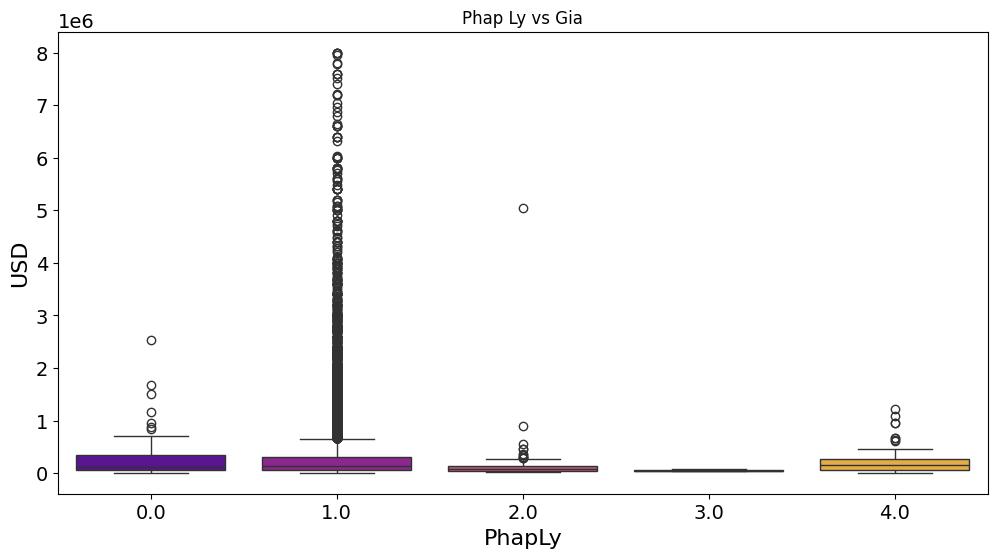

In [15]:
# Setting the figure size for the plots
plt.rcParams['figure.figsize'] = (12, 6)

sns.boxplot(x=df_raw['PhapLy'], y=df_raw['USD'], palette="plasma")
plt.title('Phap Ly vs Gia')
plt.show()

Phân phối giá trị USD theo Pháp Lý:  
Các giá trị Pháp Lý 0, 1, và 4 có sự phân tán rộng về giá trị USD.  
Pháp Lý = 1 có phạm vi giá trị rất rộng, với nhiều giá trị ngoại lai (outliers) rất cao, lên tới 8 triệu USD.  
Pháp Lý = 4 cũng có một số outliers, nhưng không rộng bằng PhapLy = 1.  
Pháp Lý = 0 và 2 có sự phân tán giá trị thấp hơn đáng kể, với ít giá trị ngoại lai và phần lớn các bất động sản có giá trị dưới 1 triệu USD.  
Pháp Lý = 3 dường như có ít dữ liệu hơn và giá trị Gia rất thấp, hầu như không có sự phân tán.  
Ảnh hưởng của Pháp Lý lên USD:  
Pháp Lý có thể là một yếu tố quan trọng ảnh hưởng đến giá trị bất động sản (USD). Đặc  
biệt, các loại pháp lý với giá trị Pháp Lý = 1 có xu hướng có các bất động sản với giá trị rất  
cao, trong khi các loại pháp lý khác có phân phối giá thấp hơn.  
Tuy nhiên, cũng có nhiều outliers, đặc biệt là đối với Pháp Lý = 1, cho thấy có sự biến động  
lớn về giá trị bất động sản trong nhóm này.  
Đánh giá tổng quan:  
Pháp Lý dường như có một tác động nhất định đến giá trị bất động sản, đặc biệt là trong nhóm  
Pháp Lý = 1, nơi có sự phân tán lớn và nhiều giá trị ngoại lai. Điều này có thể gợi ý rằng loại pháp lý  
này có liên quan đến những bất động sản có giá trị cao hoặc có nhiều biến động về giá. Cần có  
thêm phân tích để hiểu rõ hơn về lý do và các yếu tố khác có thể tương tác với Pháp Lý để ảnh  
hưởng đến USD.

In [16]:
# Hàm để tải dữ liệu JSON vào một từ điển
def load_dvhc_dict(file_name):
    with open(file_name, "r", encoding="utf8") as dvhc_file:
        dvhc_json = json.load(dvhc_file)
        dvhc_dict = {}

        for level_1_key, level_1 in dvhc_json.items():
            dvhc_dict[level_1_key] = level_1["name"]
            for level_2_key, level_2 in level_1["level2s"].items():
                dvhc_dict[level_2_key] = level_2["name"]
                for level_3_key, level_3 in level_2["level3s"].items():
                    dvhc_dict[level_3_key] = level_3["name"]

    return dvhc_dict

# Đường dẫn tới dữ liệu JSON
json_path = "C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/data/donvihanhchinhvn/dvhcvn_2024.json"
json_path_1 = "C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/data/donvihanhchinhvn/dvhcvn_2020.json"

# Tải từ điển
try:
    dvhc_dict = load_dvhc_dict(json_path)
    dvhc_dict_1 = load_dvhc_dict(json_path_1)
except KeyError as e:
    print(f"Lỗi: {e}")
    dvhc_dict = {}
    dvhc_dict_1 = {}

# Hàm để lấy tên từ ID với việc debug và chuyển đổi từ chuỗi
def get_name_from_id(id, dvhc_dict, dvhc_dict_1):
    if pd.isna(id):
        return "ID không tìm thấy"
    id_str = str(int(id)) if not isinstance(id, str) else id
    if id_str in dvhc_dict:
        return dvhc_dict[id_str]
    if id_str in dvhc_dict_1:
        return dvhc_dict_1[id_str]
    return "ID không tìm thấy"

# Hàm để định dạng ID với các số 0 đứng đầu
def format_id(id, length):
    try:
        return str(int(id)).zfill(length)  # Chuyển thành int trước khi zfill để xử lý số float
    except ValueError:
        return None  # Trong trường hợp ID không hợp lệ

# Hàm để chuyển đổi ID của thành phố, quận, và phường thành tên với định dạng và theo dõi lỗi
def convert_ids_to_names(df, dvhc_dict, dvhc_dict_1):
    # Chuyển đổi cho Thành phố
    df['City'] = df['City'].apply(lambda x: get_name_from_id(format_id(x, 2), dvhc_dict, dvhc_dict_1))
    # Chuyển đổi cho Quận
    df['District'] = df['District'].apply(lambda x: get_name_from_id(format_id(x, 3), dvhc_dict, dvhc_dict_1))
    # Chuyển đổi cho Phường
    df['Ward'] = df['Ward'].apply(lambda x: get_name_from_id(format_id(x, 5), dvhc_dict, dvhc_dict_1))
    return df

# Tạo một bản sao của df_raw
df_copy = df_raw.copy()

# Áp dụng hàm chuyển đổi vào bản sao của DataFrame
df_copy = convert_ids_to_names(df_copy, dvhc_dict, dvhc_dict_1)

In [17]:
frame1 = df_copy
bins = [40000,90000,250000,118366500]

In [18]:
def Analyst(col):
    temp = frame1.copy()
    table = temp.groupby([col])['USD'].mean()
    temp = temp.merge(table.reset_index(), how='left', on=col)
    cars_bin = ['Low', 'Medium', 'High']
    frame1['range'] = pd.cut(temp['USD_x'], bins, right=False, labels=cars_bin)
    plt.rcParams['figure.figsize'] = (18, 8)
    df = pd.DataFrame(frame1.groupby([col, 'range'])['USD'].mean().unstack(fill_value=0))
    df.plot.bar()
    plt.title('House Range vs Price')
    plt.show()

C:\Users\quanp\AppData\Local\Temp\ipykernel_15408\1922501046.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = pd.DataFrame(frame1.groupby([col, 'range'])['USD'].mean().unstack(fill_value=0))


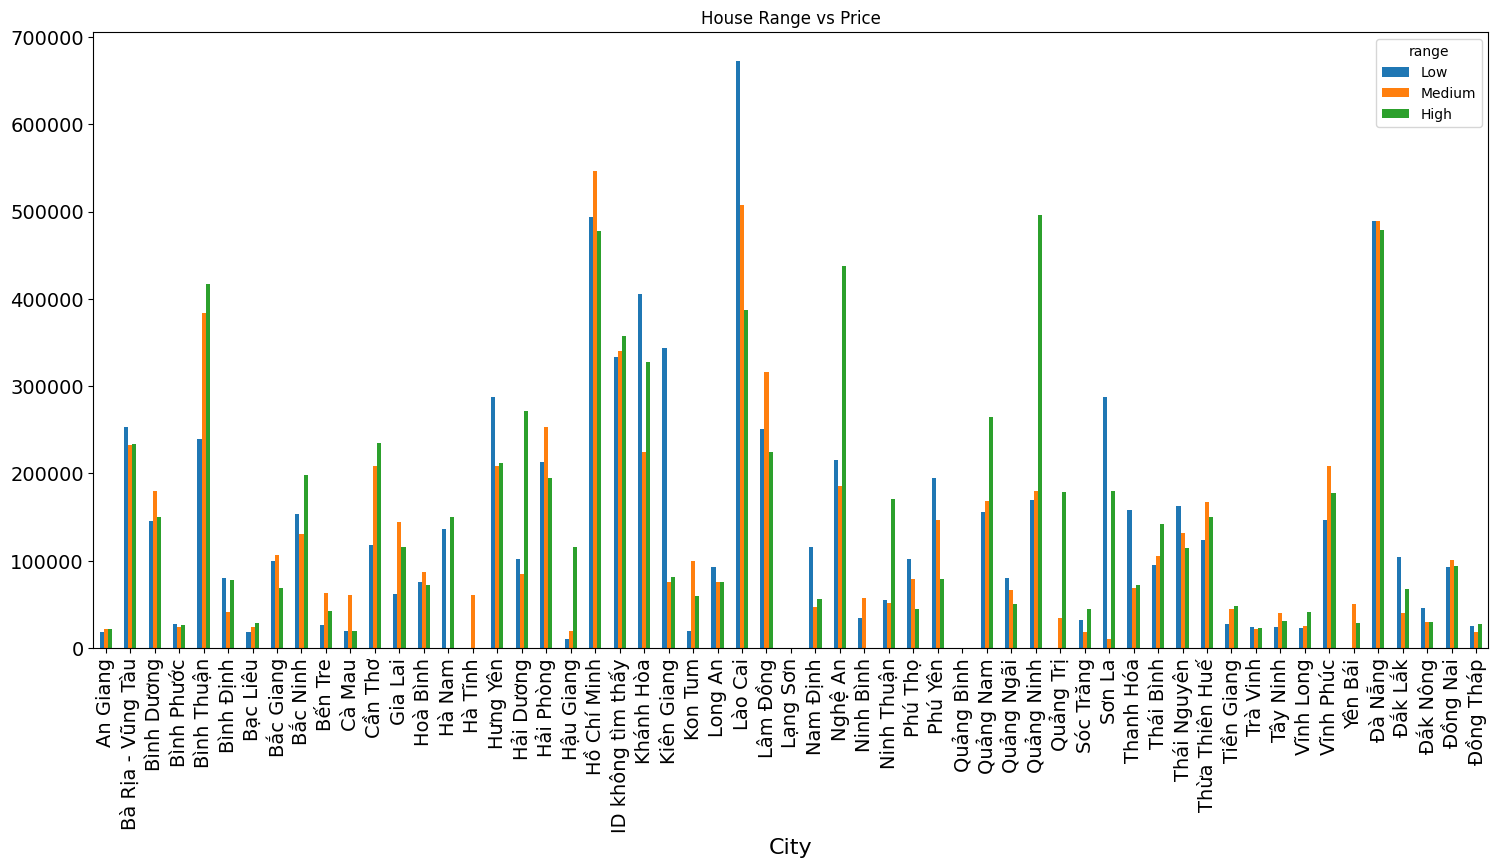

In [19]:
Analyst('City')

Sự đa dạng giá:  
- Một số thành phố như Hà Nội, Hồ Chí Minh, Đà Nẵng có giá trị cao trong cả ba phạm vi giá (Low, Medium, High).  

Phạm vi giá:  
- Ở một số thành phố, phạm vi giá cao(High) cao hơn rõ rệt so với phạm vi giá Low và Medium.  
- Trong một số trường hợp, sự chênh lệch giữa giá thấp(Low) và trung bình(Medium) không quá lớn, nhưng phạm vi giá cao(High) có sự chênh lệch rõ rệt.  

Tính chất đặc thù của từng thành phố:  
- Các thành phố lớn như Hồ Chí Minh và Hà Nội có giá trị cao hơn so với các tỉnh thành khác.  
- Một số tỉnh như Bình Dương cũng có mức giá cao, đặc biệt ở phạm vi giá cao(High).

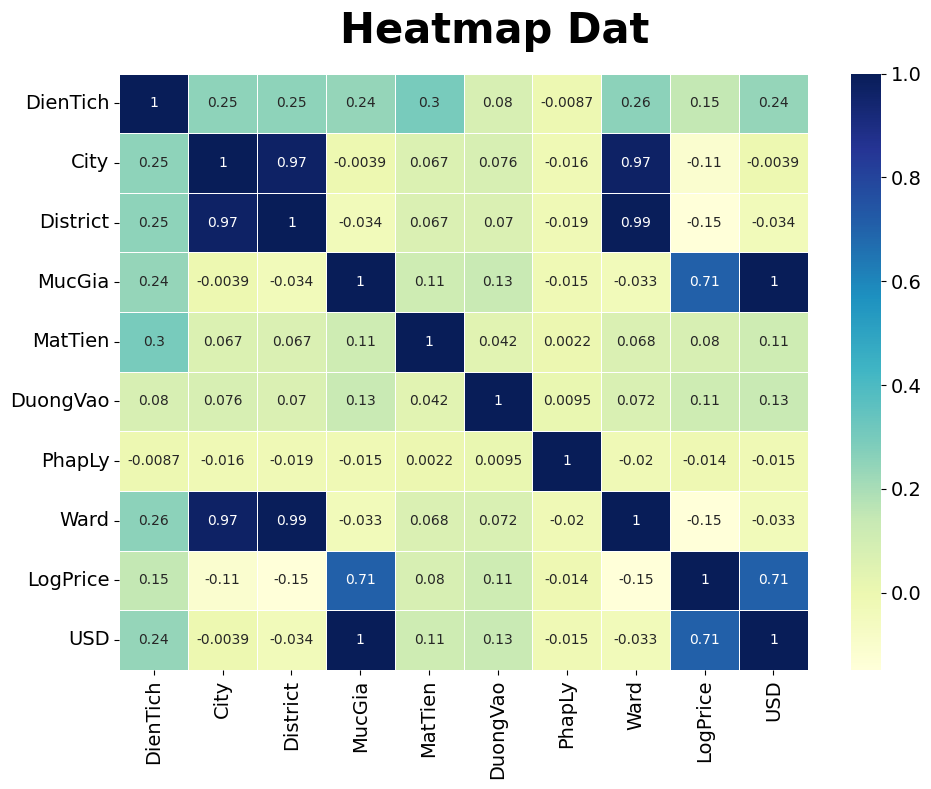

In [40]:
fig = plt.figure(figsize=(10,8))

sns.heatmap(df_raw.corr(), annot = True, cmap='YlGnBu', linewidth=.5)
fig.suptitle('Heatmap Dat',fontsize=30, fontweight="bold")
pylab.rcParams.update(rcParams)
fig.tight_layout()
plt.show()

Diện Tích (DienTich):
- Có mối tương quan mạnh với Mặt Tiền (MatTien) (0.3) và District (0.25), cho thấy rằng khi diện tích tăng, các yếu tố này cũng có xu hướng tăng.  

City và District:
- Có mối tương quan rất cao với nhau (0.97 và 0.99), cho thấy rằng dữ liệu này có thể liên quan chặt chẽ đến địa phương hoặc khu vực cụ thể.  

Pháp Lý (PhapLy):
- Biến Pháp Lý có mối tương quan thấp với các biến khác, cho thấy rằng yếu tố pháp lý có thể là một yếu tố độc lập trong việc đánh giá giá trị đất.

In [15]:
# Lấy giá trị USD cao nhất
max_usd_row = df_raw.loc[df_raw['USD'].idxmax(), ['USD', 'City']]

# Lấy giá trị USD thấp nhất
min_usd_row = df_raw.loc[df_raw['USD'].idxmin(), ['USD', 'City']]

# In ra giá trị
print("Giá trị USD cao nhất:")
print(max_usd_row)

print("\nGiá trị USD thấp nhất:")
print(min_usd_row)

Giá trị USD cao nhất:
USD     8000000.0
City          1.0
Name: 5716, dtype: object

Giá trị USD thấp nhất:
USD     8000.0
City      38.0
Name: 313, dtype: object


In [16]:
df_raw = df_raw.drop(columns=['DiaChi'])

In [17]:
df_raw.isna().sum()

DienTich       0
City           0
District       0
MucGia         0
MatTien     4695
DuongVao    5743
PhapLy         0
Ward           0
LogPrice       0
USD            0
dtype: int64

In [18]:
#Lưu dữ liệu chuẩn hóa vào file csv
df_raw.to_csv('Standardize_Land.csv')

In [19]:
df_dropped_2 = pd.read_csv('C:/CODE/SIC_BigData_Real-Estate-Price-Prediction/notebooks/Standardize_Land.csv',index_col=False)
df_dropped_2 = df_dropped_2.drop(columns=['Unnamed: 0'])

In [20]:
df_dropped_2.describe()

,DienTich,City,District,MucGia,MatTien,DuongVao,PhapLy,Ward,LogPrice,USD
count,16749.000000,16749.000000,16749.000000,1.674900e+04,12054.000000,11006.000000,16749.000000,16749.000000,16749.000000,1.674900e+04
mean,199.798140,46.525882,490.052839,7.957038e+09,8.206543,10.464792,1.013911,17808.320019,21.998936,3.182815e+05
std,208.761911,32.489088,286.673177,1.552991e+10,13.456258,17.673122,0.207594,10220.022121,1.196100,6.211963e+05
min,8.100000,1.000000,1.000000,2.000000e+08,0.380000,1.000000,0.000000,4.000000,19.113828,8.000000e+03
25%,80.000000,1.000000,274.000000,1.550000e+09,5.000000,5.000000,1.000000,9877.000000,21.161521,6.200000e+04
50%,118.000000,56.000000,568.000000,3.450000e+09,5.720000,7.500000,1.000000,22390.000000,21.961640,1.380000e+05
75%,220.000000,79.000000,761.000000,7.500000e+09,9.650000,12.000000,1.000000,26764.000000,22.738169,3.000000e+05
max,1000.000000,96.000000,973.000000,2.000000e+11,818.000000,827.000000,4.000000,32244.000000,26.021583,8.000000e+06


In [21]:
df_dropped_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16749 entries, 0 to 16748
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DienTich  16749 non-null  float64
 1   City      16749 non-null  float64
 2   District  16749 non-null  float64
 3   MucGia    16749 non-null  float64
 4   MatTien   12054 non-null  float64
 5   DuongVao  11006 non-null  float64
 6   PhapLy    16749 non-null  float64
 7   Ward      16749 non-null  float64
 8   LogPrice  16749 non-null  float64
 9   USD       16749 non-null  float64
dtypes: float64(10)
memory usage: 1.3 MB


In [22]:
X = df_dropped_2.drop(['MucGia','LogPrice','USD'], axis=1)
y = df_dropped_2['USD']

In [23]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Lưu scaler
joblib.dump(scaler, 'scaler_land.pkl')

['scaler_land.pkl']

In [26]:
# Khởi tạo và huấn luyện mô hình Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [27]:
# Dự đoán và đánh giá mô hình
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 306191.0309343466
R² Score: 0.7446026484274754


In [28]:
# Grid Search cho tối ưu hóa siêu tham số của RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Khởi tạo mô hình RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Tìm kiếm siêu tham số tối ưu
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Huấn luyện GridSearch
grid_search.fit(X_train_scaled, y_train)

# Lấy mô hình tốt nhất
best_rf_model = grid_search.best_estimator_

# Dự đoán với mô hình tốt nhất
y_pred_rf = best_rf_model.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'RMSE cho mô hình RandomForest: {rmse_rf}')
print(f'R² score cho mô hình RandomForest: {r2_rf}')

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\quanp\anaconda3\envs\test2\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RMSE cho mô hình RandomForest: 307147.107875501
R² score cho mô hình RandomForest: 0.74300520946016


In [29]:
# Tạo và huấn luyện mô hình XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - Root Mean Squared Error: {rmse_xgb}')
print(f'XGBoost - R² Score: {r2_xgb}')

XGBoost - Root Mean Squared Error: 323500.6323474937
XGBoost - R² Score: 0.7149101685777715


In [30]:
# Tạo và huấn luyện mô hình LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f'LightGBM - Root Mean Squared Error: {rmse_lgb}')
print(f'LightGBM - R² Score: {r2_lgb}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 13399, number of used features: 7
[LightGBM] [Info] Start training from score 320229.865928
LightGBM - Root Mean Squared Error: 312103.09195110167
LightGBM - R² Score: 0.7346448005972023


In [31]:
#kết hợp 3 thuật toán RandomForestRegressor,GradientBoostingRegressor,LGBMRegressor để dự đoán
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xg', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42))
]

# Tạo và huấn luyện mô hình Stacking Regressor
stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())
stacking_model.fit(X_train_scaled, y_train)

# Dự đoán trên tập kiểm tra
y_pred_stacking = stacking_model.predict(X_test_scaled)

# Tính toán các chỉ số đánh giá
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)

print(f'Mean Squared Error: {mse_stacking}')
print(f'Stacking Regressor - Root Mean Squared Error: {rmse_stacking}')
print(f'Stacking Regressor - R² Score: {r2_stacking}')

# Lưu mô hình
joblib.dump(stacking_model, 'stacking_model_Land.pkl')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 13399, number of used features: 7
[LightGBM] [Info] Start training from score 320229.865928
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 10719, number of used features: 7
[LightGBM] [Info] Start training from score 322212.443470
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

['stacking_model_Land.pkl']

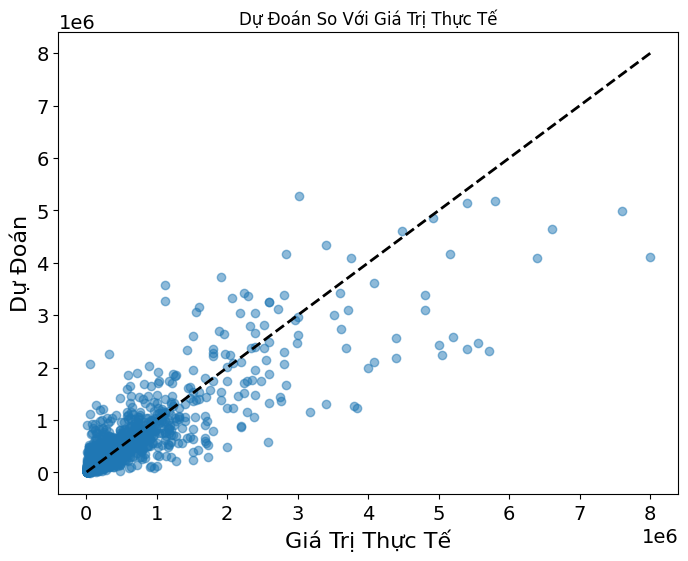

In [32]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_stacking, alpha=0.5)
plt.xlabel('Giá Trị Thực Tế')
plt.ylabel('Dự Đoán')
plt.title('Dự Đoán So Với Giá Trị Thực Tế')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

Phân tán của điểm dữ liệu: Hầu hết các điểm dữ liệu nằm dưới hoặc gần đường chính xác, cho thấy  
rằng mô hình có xu hướng dự đoán giá trị thấp hơn so với giá trị thực tế, đặc biệt là ở những  
điểm có giá trị lớn.  
Khu vực đông điểm dữ liệu: Ở khu vực có giá trị thực tế thấp (khoảng 0 đến 2 triệu USD), các điểm  
dữ liệu có xu hướng tập trung hơn, cho thấy mô hình có thể hoạt động tốt hơn trong khoảng  
giá trị này.  
Những điểm nằm xa đường chính xác: Có một số điểm nằm xa đường chính xác, cho thấy những trường  
hợp mà mô hình dự đoán có sai lệch lớn so với giá trị thực tế.  
Kết luận:  
Biểu đồ cho thấy mô hình có xu hướng dự đoán giá trị thấp hơn so với giá trị thực tế, đặc biệt ở  
những giá trị cao hơn. Điều này có thể chỉ ra rằng mô hình có thể cần được cải thiện để dự đoán  
chính xác hơn đối với các giá trị lớn.

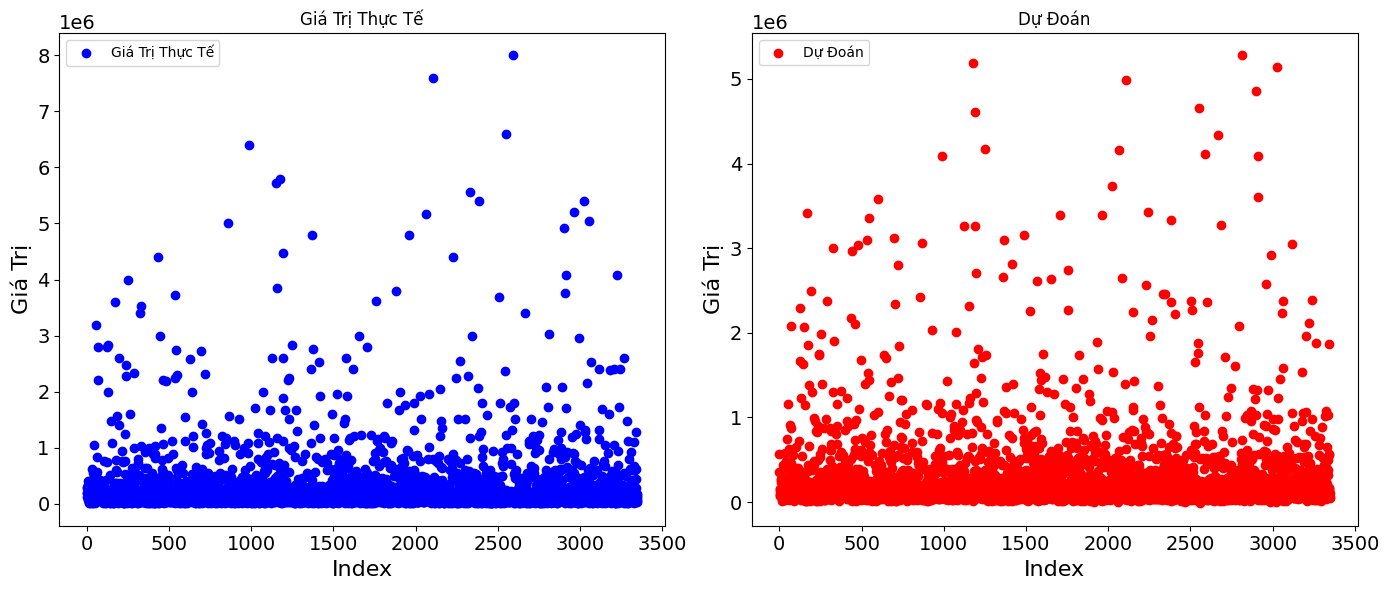

In [33]:
# Vẽ biểu đồ giá trị thực tế
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # 1 hàng, 2 cột, 1st subplot
plt.scatter(range(len(y_test)), y_test, color='blue', label='Giá Trị Thực Tế')
plt.xlabel('Index')
plt.ylabel('Giá Trị')
plt.title('Giá Trị Thực Tế')
plt.legend()

# Vẽ biểu đồ dự đoán
plt.subplot(1, 2, 2)  # 1 hàng, 2 cột, 2nd subplot
plt.scatter(range(len(y_pred_stacking)), y_pred_stacking, color='red', label='Dự Đoán')
plt.xlabel('Index')
plt.ylabel('Giá Trị')
plt.title('Dự Đoán')
plt.legend()

plt.tight_layout()
plt.show()

Biểu đồ bên trái (Giá Trị Thực Tế):  
Các điểm dữ liệu biểu thị giá trị thực tế và trải dài từ 0 đến khoảng 8 triệu USD.  
Phân tán của dữ liệu khá rộng, với một số lượng lớn các giá trị tập trung ở khoảng từ 0 đến  
2 triệu USD. Tuy nhiên, có một số điểm dữ liệu lớn hơn, trải dài đến khoảng 8 triệu USD.  
Biểu đồ bên phải (Dự Đoán):  
Các giá trị dự đoán cũng trải dài từ 0 đến khoảng 6 triệu, với một lượng lớn dữ liệu tập  
trung từ 0 đến 1 triệu.  
So với giá trị thực tế, biểu đồ này cho thấy mô hình có xu hướng dự đoán thấp hơn, và số  
lượng điểm dữ liệu với giá trị lớn hơn 4 triệu là ít hơn nhiều so với biểu đồ thực tế.  
Kết luận:  
Mô hình dự đoán có vẻ chính xác đối với các giá trị nhỏ (dưới 2 triệu USD), nhưng có sự sai lệch khi  
đối mặt với các giá trị lớn. Điều này dẫn đến việc mô hình có xu hướng dự đoán thấp hơn khi  
giá trị thực tế tăng cao.